In [2]:
import segmentation_models as sm
import os
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [3]:
x_train_dir = "./train/image"
y_train_dir = "./train/label"

x_valid_dir = "./validate/image"
y_valid_dir = "./validate/label"

x_test_dir = "./test/image"
y_test_dir = "./test/label"

# Przechowywanie danych i funkcje pomocnicze

In [21]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()
      
def denormalize(x):
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    
class Dataset:
    CLASSES = ['vein']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            names=False,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.names=names
        self.augmentation = augmentation
    
    def __getitem__(self, i):
        
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        masks = [(mask > 0)]
        mask = np.stack(masks, axis=-1).astype('float')
        
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.names:
            name = self.images_fps[i].split('/')[-1]
            return image, mask, name
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.all_utils.Sequence):
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        
        self.on_epoch_end()

    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

# Modyfikacje obrazu

In [5]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(None,None,pad_height_divisor=32, pad_width_divisor=32, always_apply=True, border_mode=0),
        A.RandomCrop(height=576, width=576, p=1),

        A.augmentations.transforms.GaussNoise(p=0.2),
        A.augmentations.geometric.transforms.Perspective(p=0.3),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.augmentations.transforms.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.PadIfNeeded(None,None,pad_height_divisor=32, pad_width_divisor=32, border_mode=0)
    ]
    return A.Compose(test_transform)

# Definicja parametrów i stworzenie modelu

In [12]:
BATCH_SIZE = 1
LR = 0.0001
EPOCHS = 300

In [13]:
model = sm.Unet('resnet152', classes=1, activation='sigmoid')

In [14]:
optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

# Wczytanie danych

51 18


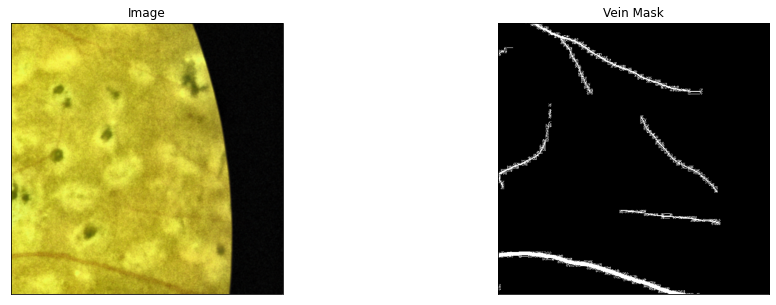

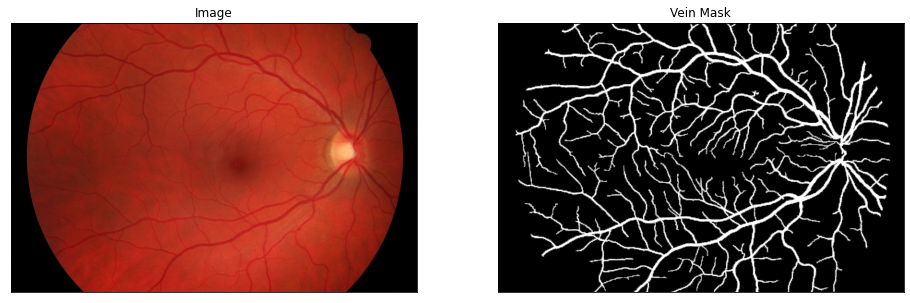

In [28]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes = ['vein'],
    augmentation=get_training_augmentation(),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes = ['vein'],
    augmentation=get_validation_augmentation(),
)

image, mask, name = train_dataset[5] 
visualize(
    image=image, 
    vein_mask=mask[..., 0].squeeze(),
)

image, mask, name = valid_dataset[7]
visualize(
    image=image, 
    vein_mask=mask[..., 0].squeeze(),
)
train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

# Uczenie modelu

In [9]:
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/300


2022-05-09 13:06:05.343048: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-09 13:06:06.845524: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-09 13:06:06.845562: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-09 13:06:08.908581: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

51/51 [==============================] - ETA: 0s - loss: 0.9149 - iou_score: 0.1826 - f1-score: 0.3027

2022-05-09 13:06:27.357368: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-09 13:06:27.357399: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.71GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-09 13:06:31.145109: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.26GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-09 13:06:31.145138: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

51/51 [==============================] - 61s 903ms/step - loss: 0.9149 - iou_score: 0.1826 - f1-score: 0.3027 - val_loss: 0.9007 - val_iou_score: 0.1481 - val_f1-score: 0.2574 - lr: 1.0000e-04
Epoch 2/300
51/51 [==============================] - 24s 473ms/step - loss: 0.7960 - iou_score: 0.2846 - f1-score: 0.4259 - val_loss: 0.8392 - val_iou_score: 0.1545 - val_f1-score: 0.2641 - lr: 1.0000e-04
Epoch 3/300
51/51 [==============================] - 24s 469ms/step - loss: 0.7075 - iou_score: 0.3895 - f1-score: 0.5479 - val_loss: 0.8167 - val_iou_score: 0.1599 - val_f1-score: 0.2716 - lr: 1.0000e-04
Epoch 4/300
51/51 [==============================] - 24s 474ms/step - loss: 0.6798 - iou_score: 0.3913 - f1-score: 0.5449 - val_loss: 0.7103 - val_iou_score: 0.3707 - val_f1-score: 0.5299 - lr: 1.0000e-04
Epoch 5/300
51/51 [==============================] - 24s 476ms/step - loss: 0.6179 - iou_score: 0.4309 - f1-score: 0.5921 - val_loss: 0.6929 - val_iou_score: 0.2959 - val_f1-score: 0.4484 - lr

Epoch 41/300
51/51 [==============================] - 23s 451ms/step - loss: 0.4431 - iou_score: 0.5083 - f1-score: 0.6645 - val_loss: 0.4017 - val_iou_score: 0.5306 - val_f1-score: 0.6910 - lr: 1.0000e-05
Epoch 42/300
51/51 [==============================] - 24s 475ms/step - loss: 0.4202 - iou_score: 0.5277 - f1-score: 0.6851 - val_loss: 0.3987 - val_iou_score: 0.5336 - val_f1-score: 0.6936 - lr: 1.0000e-05
Epoch 43/300
51/51 [==============================] - 23s 451ms/step - loss: 0.4059 - iou_score: 0.5413 - f1-score: 0.6984 - val_loss: 0.4037 - val_iou_score: 0.5283 - val_f1-score: 0.6891 - lr: 1.0000e-05
Epoch 44/300
51/51 [==============================] - 24s 474ms/step - loss: 0.4240 - iou_score: 0.5451 - f1-score: 0.7006 - val_loss: 0.3934 - val_iou_score: 0.5381 - val_f1-score: 0.6974 - lr: 1.0000e-05
Epoch 45/300
51/51 [==============================] - 23s 447ms/step - loss: 0.4484 - iou_score: 0.4986 - f1-score: 0.6534 - val_loss: 0.3938 - val_iou_score: 0.5371 - val_f1-s

Epoch 81/300
51/51 [==============================] - 23s 451ms/step - loss: 0.4085 - iou_score: 0.5382 - f1-score: 0.6926 - val_loss: 0.3874 - val_iou_score: 0.5444 - val_f1-score: 0.7029 - lr: 1.0000e-07
Epoch 82/300
51/51 [==============================] - 23s 450ms/step - loss: 0.3929 - iou_score: 0.5545 - f1-score: 0.7091 - val_loss: 0.4037 - val_iou_score: 0.5299 - val_f1-score: 0.6906 - lr: 1.0000e-07
Epoch 83/300
51/51 [==============================] - 23s 450ms/step - loss: 0.4316 - iou_score: 0.5263 - f1-score: 0.6796 - val_loss: 0.3896 - val_iou_score: 0.5418 - val_f1-score: 0.7007 - lr: 1.0000e-07
Epoch 84/300
51/51 [==============================] - 23s 449ms/step - loss: 0.3966 - iou_score: 0.5514 - f1-score: 0.7037 - val_loss: 0.3801 - val_iou_score: 0.5520 - val_f1-score: 0.7093 - lr: 1.0000e-07
Epoch 85/300
51/51 [==============================] - 23s 450ms/step - loss: 0.4188 - iou_score: 0.5303 - f1-score: 0.6804 - val_loss: 0.3760 - val_iou_score: 0.5563 - val_f1-s

Epoch 121/300
51/51 [==============================] - 23s 445ms/step - loss: 0.4416 - iou_score: 0.5454 - f1-score: 0.6947 - val_loss: 0.3919 - val_iou_score: 0.5401 - val_f1-score: 0.6993 - lr: 1.0000e-10
Epoch 122/300
51/51 [==============================] - 23s 449ms/step - loss: 0.4208 - iou_score: 0.5260 - f1-score: 0.6825 - val_loss: 0.3853 - val_iou_score: 0.5469 - val_f1-score: 0.7050 - lr: 1.0000e-10
Epoch 123/300
51/51 [==============================] - 23s 447ms/step - loss: 0.4323 - iou_score: 0.5235 - f1-score: 0.6774 - val_loss: 0.3788 - val_iou_score: 0.5529 - val_f1-score: 0.7101 - lr: 1.0000e-10
Epoch 124/300
51/51 [==============================] - 23s 446ms/step - loss: 0.4359 - iou_score: 0.5498 - f1-score: 0.7016 - val_loss: 0.3795 - val_iou_score: 0.5522 - val_f1-score: 0.7095 - lr: 1.0000e-11
Epoch 125/300
51/51 [==============================] - 23s 447ms/step - loss: 0.4296 - iou_score: 0.5586 - f1-score: 0.7096 - val_loss: 0.3830 - val_iou_score: 0.5488 - val

Epoch 161/300
51/51 [==============================] - 23s 448ms/step - loss: 0.4213 - iou_score: 0.5240 - f1-score: 0.6786 - val_loss: 0.3933 - val_iou_score: 0.5382 - val_f1-score: 0.6977 - lr: 1.0000e-13
Epoch 162/300
51/51 [==============================] - 23s 448ms/step - loss: 0.4089 - iou_score: 0.5404 - f1-score: 0.6924 - val_loss: 0.3881 - val_iou_score: 0.5434 - val_f1-score: 0.7020 - lr: 1.0000e-14
Epoch 163/300
51/51 [==============================] - 23s 452ms/step - loss: 0.4138 - iou_score: 0.5535 - f1-score: 0.7076 - val_loss: 0.3806 - val_iou_score: 0.5509 - val_f1-score: 0.7083 - lr: 1.0000e-14
Epoch 164/300
51/51 [==============================] - 23s 446ms/step - loss: 0.4251 - iou_score: 0.5249 - f1-score: 0.6761 - val_loss: 0.3773 - val_iou_score: 0.5547 - val_f1-score: 0.7115 - lr: 1.0000e-14
Epoch 165/300
51/51 [==============================] - 25s 481ms/step - loss: 0.4331 - iou_score: 0.5172 - f1-score: 0.6672 - val_loss: 0.3705 - val_iou_score: 0.5615 - val

Epoch 201/300
51/51 [==============================] - 23s 454ms/step - loss: 0.4041 - iou_score: 0.5459 - f1-score: 0.7026 - val_loss: 0.4034 - val_iou_score: 0.5298 - val_f1-score: 0.6905 - lr: 1.0000e-17
Epoch 202/300
51/51 [==============================] - 23s 453ms/step - loss: 0.4302 - iou_score: 0.5401 - f1-score: 0.6907 - val_loss: 0.3985 - val_iou_score: 0.5336 - val_f1-score: 0.6938 - lr: 1.0000e-17
Epoch 203/300
51/51 [==============================] - 23s 450ms/step - loss: 0.4019 - iou_score: 0.5445 - f1-score: 0.7007 - val_loss: 0.3849 - val_iou_score: 0.5472 - val_f1-score: 0.7052 - lr: 1.0000e-17
Epoch 204/300
51/51 [==============================] - 23s 450ms/step - loss: 0.4169 - iou_score: 0.5473 - f1-score: 0.7024 - val_loss: 0.3803 - val_iou_score: 0.5512 - val_f1-score: 0.7086 - lr: 1.0000e-17
Epoch 205/300
51/51 [==============================] - 23s 448ms/step - loss: 0.4166 - iou_score: 0.5565 - f1-score: 0.7099 - val_loss: 0.3756 - val_iou_score: 0.5563 - val

Epoch 241/300
51/51 [==============================] - 23s 452ms/step - loss: 0.4514 - iou_score: 0.5352 - f1-score: 0.6876 - val_loss: 0.3747 - val_iou_score: 0.5576 - val_f1-score: 0.7140 - lr: 1.0000e-21
Epoch 242/300
51/51 [==============================] - 23s 459ms/step - loss: 0.4316 - iou_score: 0.5170 - f1-score: 0.6716 - val_loss: 0.3841 - val_iou_score: 0.5478 - val_f1-score: 0.7058 - lr: 1.0000e-21
Epoch 243/300
51/51 [==============================] - 23s 452ms/step - loss: 0.4255 - iou_score: 0.5416 - f1-score: 0.6930 - val_loss: 0.3828 - val_iou_score: 0.5492 - val_f1-score: 0.7070 - lr: 1.0000e-21
Epoch 244/300
51/51 [==============================] - 23s 454ms/step - loss: 0.4481 - iou_score: 0.4983 - f1-score: 0.6511 - val_loss: 0.3941 - val_iou_score: 0.5376 - val_f1-score: 0.6971 - lr: 1.0000e-21
Epoch 245/300
51/51 [==============================] - 23s 449ms/step - loss: 0.4253 - iou_score: 0.5278 - f1-score: 0.6865 - val_loss: 0.3803 - val_iou_score: 0.5512 - val

Epoch 281/300
51/51 [==============================] - 23s 462ms/step - loss: 0.4128 - iou_score: 0.5364 - f1-score: 0.6928 - val_loss: 0.3752 - val_iou_score: 0.5567 - val_f1-score: 0.7133 - lr: 1.0000e-25
Epoch 282/300
51/51 [==============================] - 23s 452ms/step - loss: 0.4072 - iou_score: 0.5432 - f1-score: 0.6957 - val_loss: 0.3765 - val_iou_score: 0.5553 - val_f1-score: 0.7121 - lr: 1.0000e-25
Epoch 283/300
51/51 [==============================] - 23s 451ms/step - loss: 0.4220 - iou_score: 0.5313 - f1-score: 0.6845 - val_loss: 0.3761 - val_iou_score: 0.5559 - val_f1-score: 0.7125 - lr: 1.0000e-25
Epoch 284/300
51/51 [==============================] - 23s 453ms/step - loss: 0.4183 - iou_score: 0.5299 - f1-score: 0.6804 - val_loss: 0.3850 - val_iou_score: 0.5467 - val_f1-score: 0.7049 - lr: 1.0000e-25
Epoch 285/300
51/51 [==============================] - 23s 454ms/step - loss: 0.4036 - iou_score: 0.5636 - f1-score: 0.7161 - val_loss: 0.3824 - val_iou_score: 0.5495 - val

# Wykres postępów

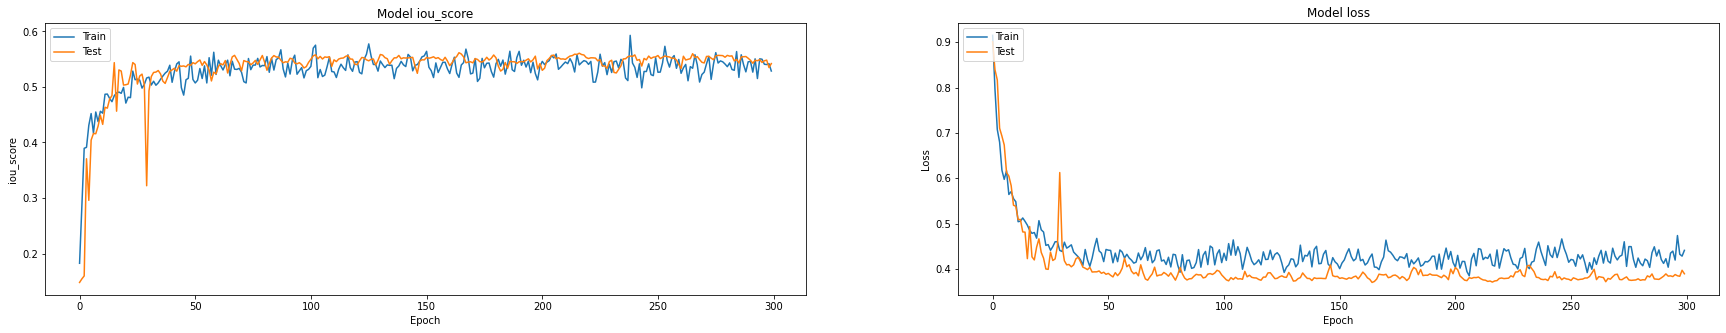

In [10]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Testy na zbiorze testowym

In [22]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir,  
    classes = ['vein'],
    augmentation=get_validation_augmentation(),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [16]:
model.load_weights('best_model.h5') 

In [23]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

2022-05-09 21:11:38.702641: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-09 21:11:46.034039: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-09 21:11:46.034088: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.32GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-09 21:11:46.161274: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.23GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

14/14 [==============================] - 39s 1s/step - loss: 0.3510 - iou_score: 0.5805 - f1-score: 0.7325
Loss: 0.35102
mean iou_score: 0.5805
mean f1-score: 0.73249


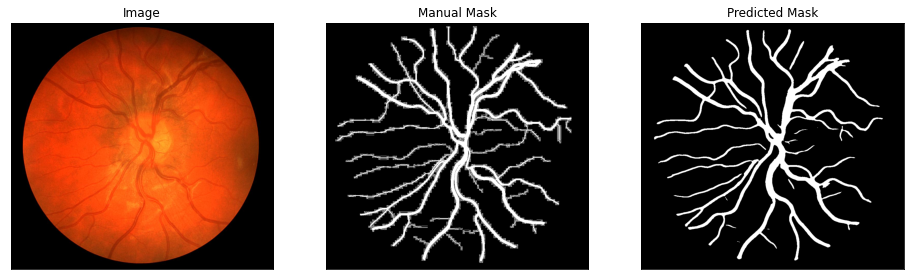

Sensitivity:  0.7003857974236579
Specificity:  0.9794480281074851
Positive predictive value:  0.8288884374667479
Negative predictive value:  0.9583294966367802
Accuaracy:  0.9447174072265625
F-measure:  0.7592381745606301


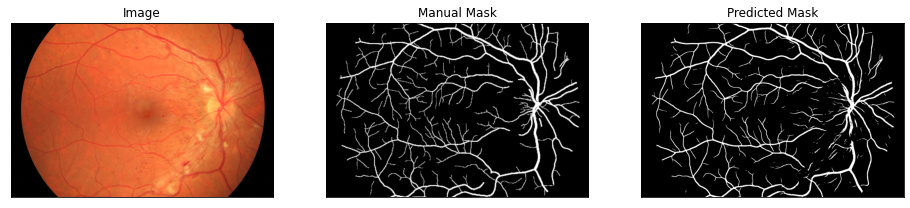

Sensitivity:  0.7252938127722759
Specificity:  0.9744352929992991
Positive predictive value:  0.7497202821135879
Negative predictive value:  0.971094700728632
Accuaracy:  0.9506420016734122
F-measure:  0.7373047943232665


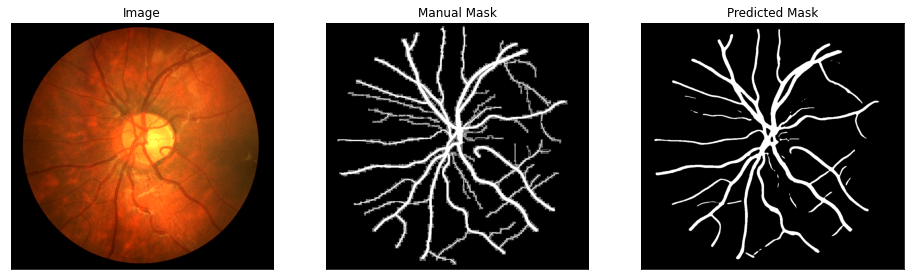

Sensitivity:  0.6411859799968024
Specificity:  0.985612171983025
Positive predictive value:  0.8521544091606658
Negative predictive value:  0.9550321151469949
Accuaracy:  0.9461669921875
F-measure:  0.7317681406240496


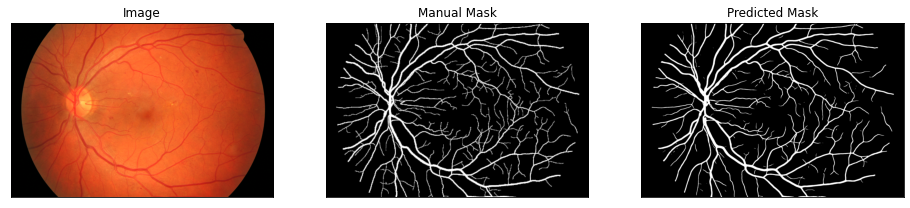

Sensitivity:  0.7480180637814483
Specificity:  0.9726672767385856
Positive predictive value:  0.7698815780704557
Negative predictive value:  0.9693021719858518
Accuaracy:  0.9481958524673101
F-measure:  0.7587923621441308


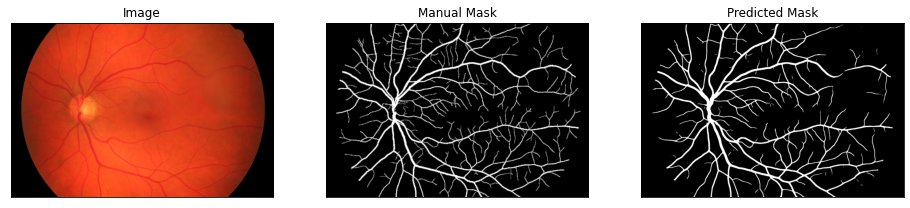

Sensitivity:  0.7419666017754631
Specificity:  0.9746006509487927
Positive predictive value:  0.7598003413469566
Negative predictive value:  0.9721298796036288
Accuaracy:  0.9518712786036737
F-measure:  0.7507775822058208


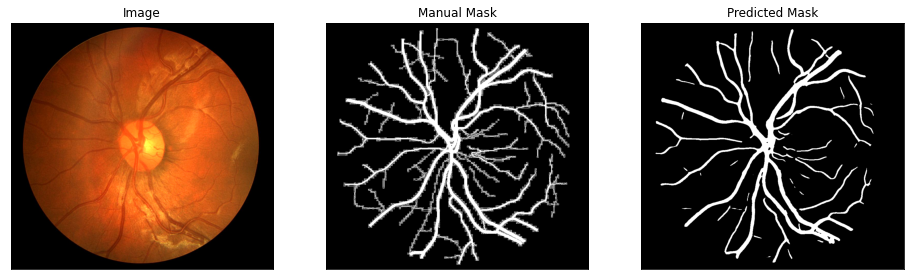

Sensitivity:  0.6121598671547722
Specificity:  0.9848992716520389
Positive predictive value:  0.8632831626679156
Negative predictive value:  0.94220746062846
Accuaracy:  0.9346649169921875
F-measure:  0.7163506763649854


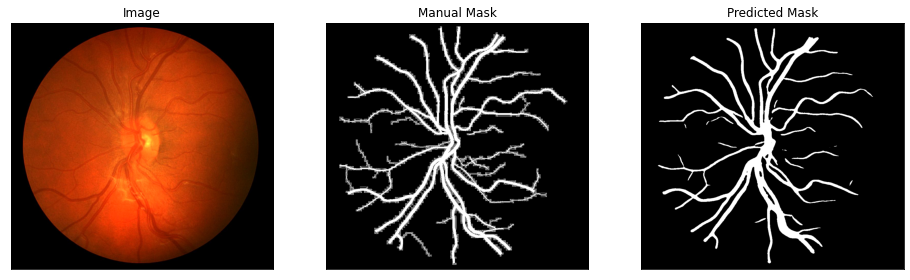

Sensitivity:  0.67310661345977
Specificity:  0.9840175174578865
Positive predictive value:  0.8523840557259004
Negative predictive value:  0.9564365853082674
Accuaracy:  0.9465291341145833
F-measure:  0.7522108875605754


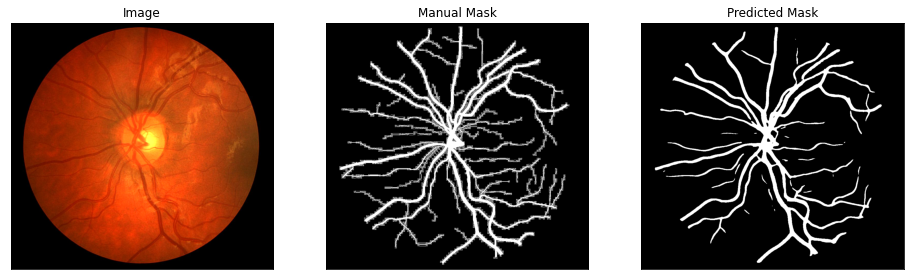

Sensitivity:  0.6273705713763035
Specificity:  0.9817514392238991
Positive predictive value:  0.8411360129175992
Negative predictive value:  0.9447733760812662
Accuaracy:  0.9344573974609375
F-measure:  0.718694742908537


In [24]:
presentation_dataset = Dataset(
    x_test_dir, 
    y_test_dir,  
    classes = ['vein'],
    augmentation=get_validation_augmentation(),
    names=True,
)

names = ['17', '19', '43', '80', '82', '84', '86', '88']

for i in range(len(presentation_dataset)):
    
    image, manual_mask, name = presentation_dataset[i]
    if name.split('.')[0] in names:
        image = np.expand_dims(image, axis=0)
        predicted_mask = model.predict(image).round().squeeze()
        manual_mask = manual_mask.squeeze()

        visualize(
            image=denormalize(image.squeeze()),
            manual_mask=manual_mask,
            predicted_mask=predicted_mask,
        )
        cv2.imwrite('testy/' + name.split('.')[0] + '_predicted.jpg', predicted_mask*255)
        tp, tn, fp, fn = 0, 0, 0, 0
        for row in range(len(manual_mask)):
            for pixel in range(len(manual_mask[0])):
                if manual_mask[row][pixel] == True and predicted_mask[row][pixel] == True:
                    tp += 1
                elif manual_mask[row][pixel] == False and predicted_mask[row][pixel] == False:
                    tn += 1
                elif manual_mask[row][pixel] == False and predicted_mask[row][pixel] == True:
                    fp += 1
                elif manual_mask[row][pixel] == True and predicted_mask[row][pixel] == False:
                    fn += 1
        tpr = tp / (tp + fn)
        tnr = tn / (tn + fp)
        ppv = tp / (tp + fp)
        npv = tn / (tn + fn)
        acc = (tp+tn)/(tp+tn+fp+fn)
        f_measure = 2 / ((1 / ppv) + (1 / tpr))
        print("Sensitivity: ", tpr)
        print("Specificity: ", tnr)
        print("Positive predictive value: ", ppv)
        print("Negative predictive value: ", npv)
        print("Accuaracy: ", acc)
        print("F-measure: ", f_measure)
            